In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
pd.set_option('display.max_colwidth', 50)


In [ ]:
df=pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
df.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [ ]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]


BASE_LEN = 89 
END_IMG_LEN = 4 
END_MASK_LEN = 9 

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_4.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_4_mask.tif


In [ ]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df.head()

patient_id                                         image_path  \
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  mask  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0

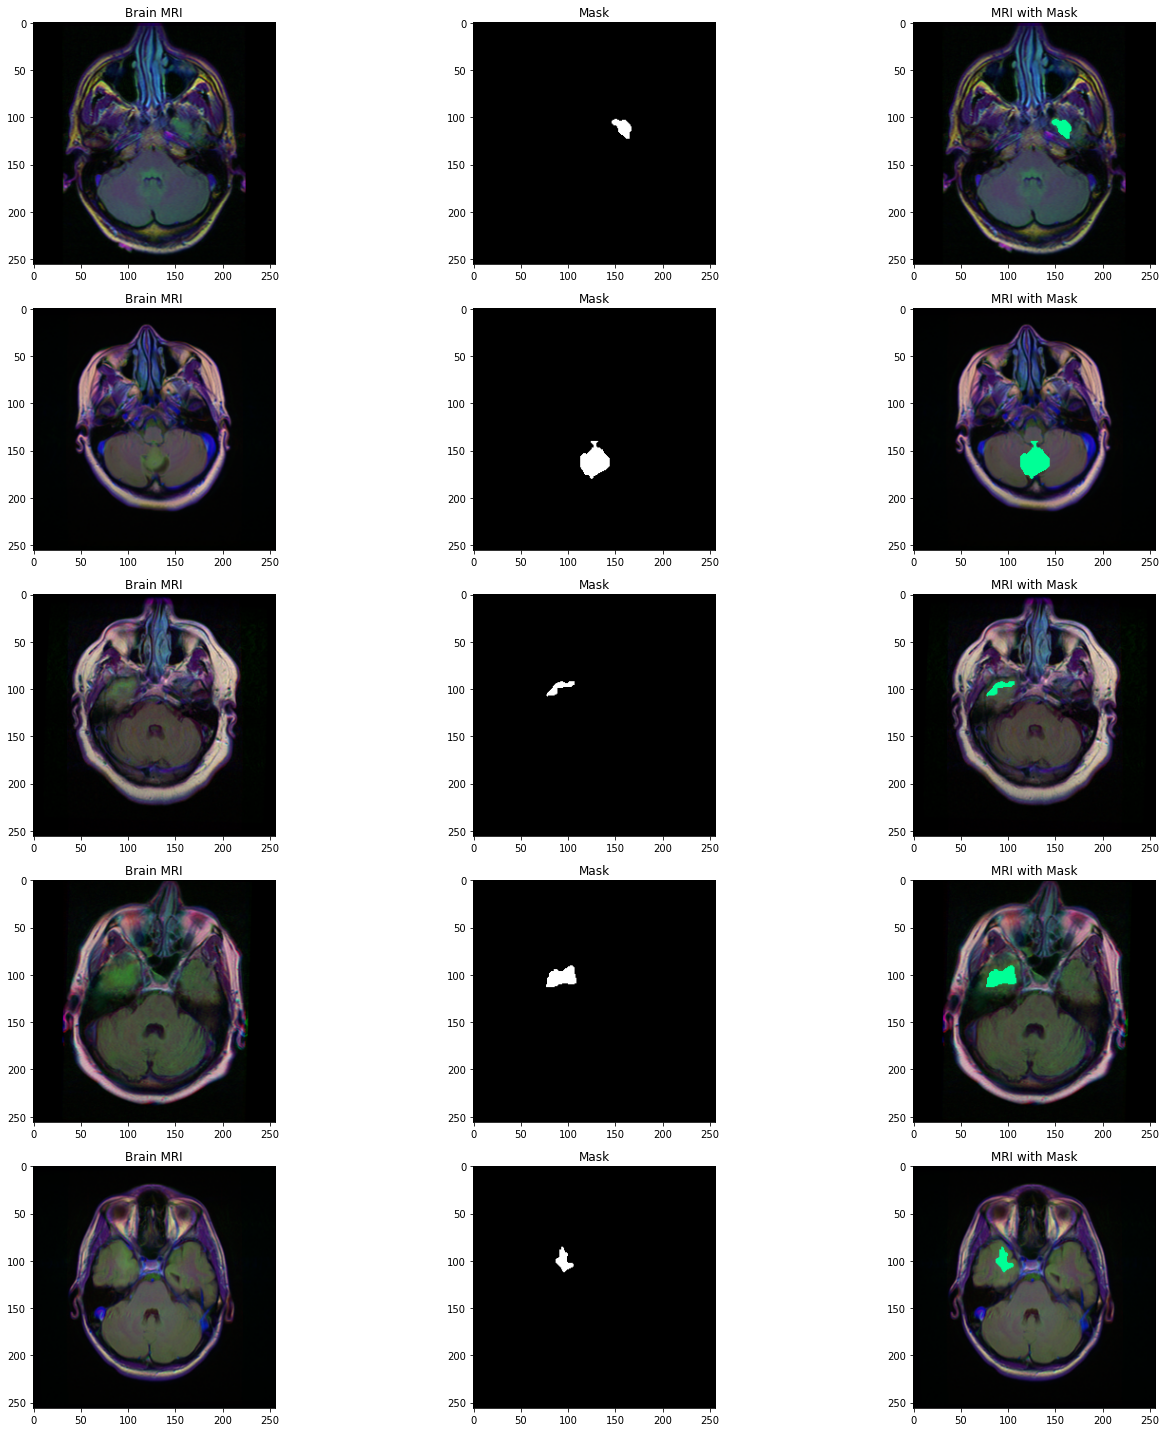

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(5,3, figsize=(20,20))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==5):
        break
        
fig.tight_layout()

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size=0.15)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Get the number of batches per epoch'

        return int(np.floor(len(self.ids)) / self.batch_size)

    def __getitem__(self, index):
        'Generate a batch of data'

        #generate index of batch_size length
        indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

        #get the ImageId corresponding to the indexes created above based on batch size
        list_ids = [self.ids[i] for i in indexes]

        #get the MaskId corresponding to the indexes created above based on batch size
        list_mask = [self.mask[i] for i in indexes]


        #generate data for the X(features) and y(label)
        X, y = self.__data_generation(list_ids, list_mask)

        #returning the data
        return X, y

    def on_epoch_end(self):
        'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'

        #getting the array of indices based on the input dataframe
        self.indexes = np.arange(len(self.ids))

        #if shuffle is true, shuffle the indices
        if self.shuffle:
          np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        'generate the data corresponding the indexes in a given batch of images'

        # create empty arrays of shape (batch_size,height,width,depth) 
        #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        #iterate through the dataframe rows, whose size is equal to the batch_size
        for i in range(len(list_ids)):
            #path of the image
            img_path = str(list_ids[i])

            #mask path
            mask_path = str(list_mask[i])

            #reading the original image and the corresponding mask image
            img = io.imread(img_path)
            mask = io.imread(mask_path)

            #resizing and coverting them to array of type float64
            img = cv2.resize(img,(self.img_h,self.img_w))
            img = np.array(img, dtype = np.float64)

            mask = cv2.resize(mask,(self.img_h,self.img_w))
            mask = np.array(mask, dtype = np.float64)

            #standardising 
            img -= img.mean()
            img /= img.std()

            mask -= mask.mean()
            mask /= mask.std()

            #Adding image to the empty array
            X[i,] = img

            #expanding the dimnesion of the image from (256,256) to (256,256,1)
            y[i,] = np.expand_dims(mask, axis = 2)

        #normalizing y
        y = (y > 0).astype(int)

        return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [ ]:
# lets create model now
def resblock(X, f): #f = filters
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

ResUNet model:

The RESUNET consists of an encoding network, decoding network and a bridge connecting both these networks, just like a U-Net. The U-Net uses two 3 x 3 convolution, where each is followed by a ReLU activation function. In the case of RESUNET, these layers are replaced by a pre-activated residual block.

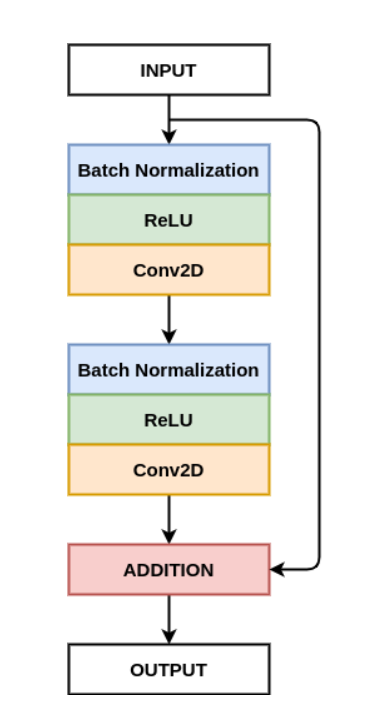 



Encoder

The encoder takes the input image and passes it through different encoder blocks, which helps the network to learn an abstract representation. The encoder consists of three encoder blocks, which are built using the pre-activated residual block. The output of each encoder block acts as a skip connection for the corresponding decoder block.
To reduce the spatial dimensions (height and width) of the feature maps, the first 3×3 convolution layer uses a stride of 2 in the second and the third encoder block. A stride value of 2 reduces the spatial dimensions by half, i.e. 256 to 128.

Bridge

The bridge also consists of a pre-activated residual block with a stride value of 2.

Decoder

The decoder takes the feature map from the bridge and the skip connections from different encoder block and learns a better semantic representation, which is used to generate a segmentation mask.
The decoder consists of three decoder blocks, and after each block, the spatial dimensions of the feature map are doubles and the number of feature channels is reduced.
Each decoder block begins with a 2×2 upsampling, which doubles the spatial dimensions of the feature maps. Next, these feature maps are then concatenated with the appropriate skip connection from the encoder block. These skip connections help the decoder blocks to get the feature learned by the encoder network. After this, the feature maps from the concatenation operation are passes through a pre-activated residual block.
The output of the last decoder passes through a 1×1 convolution with sigmoid activation. The sigmoid activation function gives the segmentation mask representing the pixel-wise classification.

In [ ]:
ResUNet model:

The RESUNET consists of an encoding network, decoding network and a bridge connecting both these networks, just like a U-Net. The U-Net uses two 3 x 3 convolution, where each is followed by a ReLU activation function. In the case of RESUNET, these layers are replaced by a pre-activated residual block


In [ ]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape
#ENCODER
# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)
#DECODER
# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
# seg_model.summary()

In [ ]:
from keras.losses import binary_crossentropy

smooth = 1

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss='mse', #loss='mse', #loss = focal_tversky, 
                  metrics = [iou_coef]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=10
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights_v5.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
h = seg_model.fit(train_data, 
                  epochs = 80, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )


Epoch 1/80
72/72 [==============================] - 25s 256ms/step - loss: 0.0733 - iou_coef: 0.0142 - val_loss: 0.0506 - val_iou_coef: 0.0289

Epoch 00001: val_loss improved from inf to 0.05059, saving model to ResUNet-segModel-weights_v5.hdf5
Epoch 2/80
72/72 [==============================] - 10s 140ms/step - loss: 0.0236 - iou_coef: 0.0740 - val_loss: 0.0301 - val_iou_coef: 0.0941

Epoch 00002: val_loss improved from 0.05059 to 0.03006, saving model to ResUNet-segModel-weights_v5.hdf5
Epoch 3/80
72/72 [==============================] - 9s 124ms/step - loss: 0.0182 - iou_coef: 0.1489 - val_loss: 0.0229 - val_iou_coef: 0.1331

Epoch 00003: val_loss improved from 0.03006 to 0.02286, saving model to ResUNet-segModel-weights_v5.hdf5
Epoch 4/80
72/72 [==============================] - 9s 124ms/step - loss: 0.0162 - iou_coef: 0.1812 - val_loss: 0.0192 - val_iou_coef: 0.1749

Epoch 00004: val_loss improved from 0.02286 to 0.01924, saving model to ResUNet-segModel-weights_v5.hdf5
Epoch 5/80

In [ ]:
import subprocess
import pprint

sp = subprocess.Popen(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out_str = sp.communicate()
out_list = str(out_str[0]).split('\\n')

out_dict = {}

for item in out_list:
    print(item)

b'Sun Apr 25 08:17:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    46W / 250W |  15537MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----

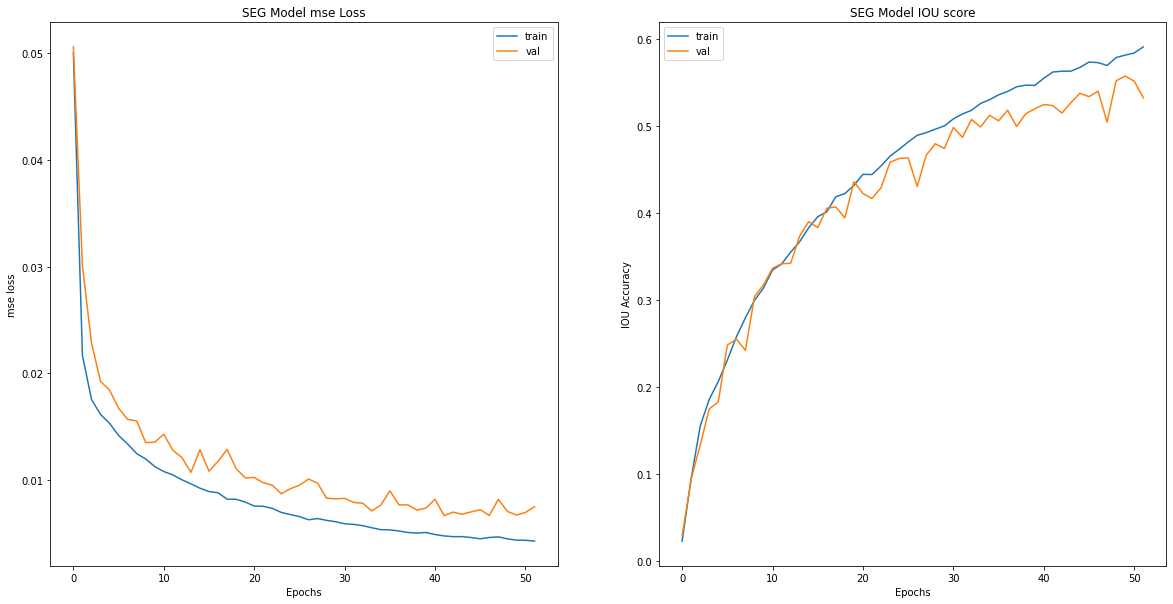

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model mse Loss");
plt.ylabel("mse loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['iou_coef']);
plt.plot(h.history['val_iou_coef']);
plt.title("SEG Model IOU score");
plt.ylabel("IOU Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.savefig('Central_Model_Performance.png')

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation IOU is {:.2f}%".format(tv*100))

6/6 [==============================] - 1s 219ms/step - loss: 0.0063 - iou_coef: 0.5741
Segmentation IOU is 57.41%


In [ ]:
def prediction(test, model_seg):
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [ ]:
# making prediction
pd.set_option('display.max_colwidth', 50)
df_pred = prediction(test, seg_model)
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(5)

image_path  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path mask  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1  [[[[0.00407146], [0.00195795], [0.0030647], [0...         1  
2  [[[[0.00592896], [0.00234999], [0.00350941], [...         1  
3                                            No mask         0  
4  [[[[0.005839], [0.00228575], [0.00320534], [0....         1

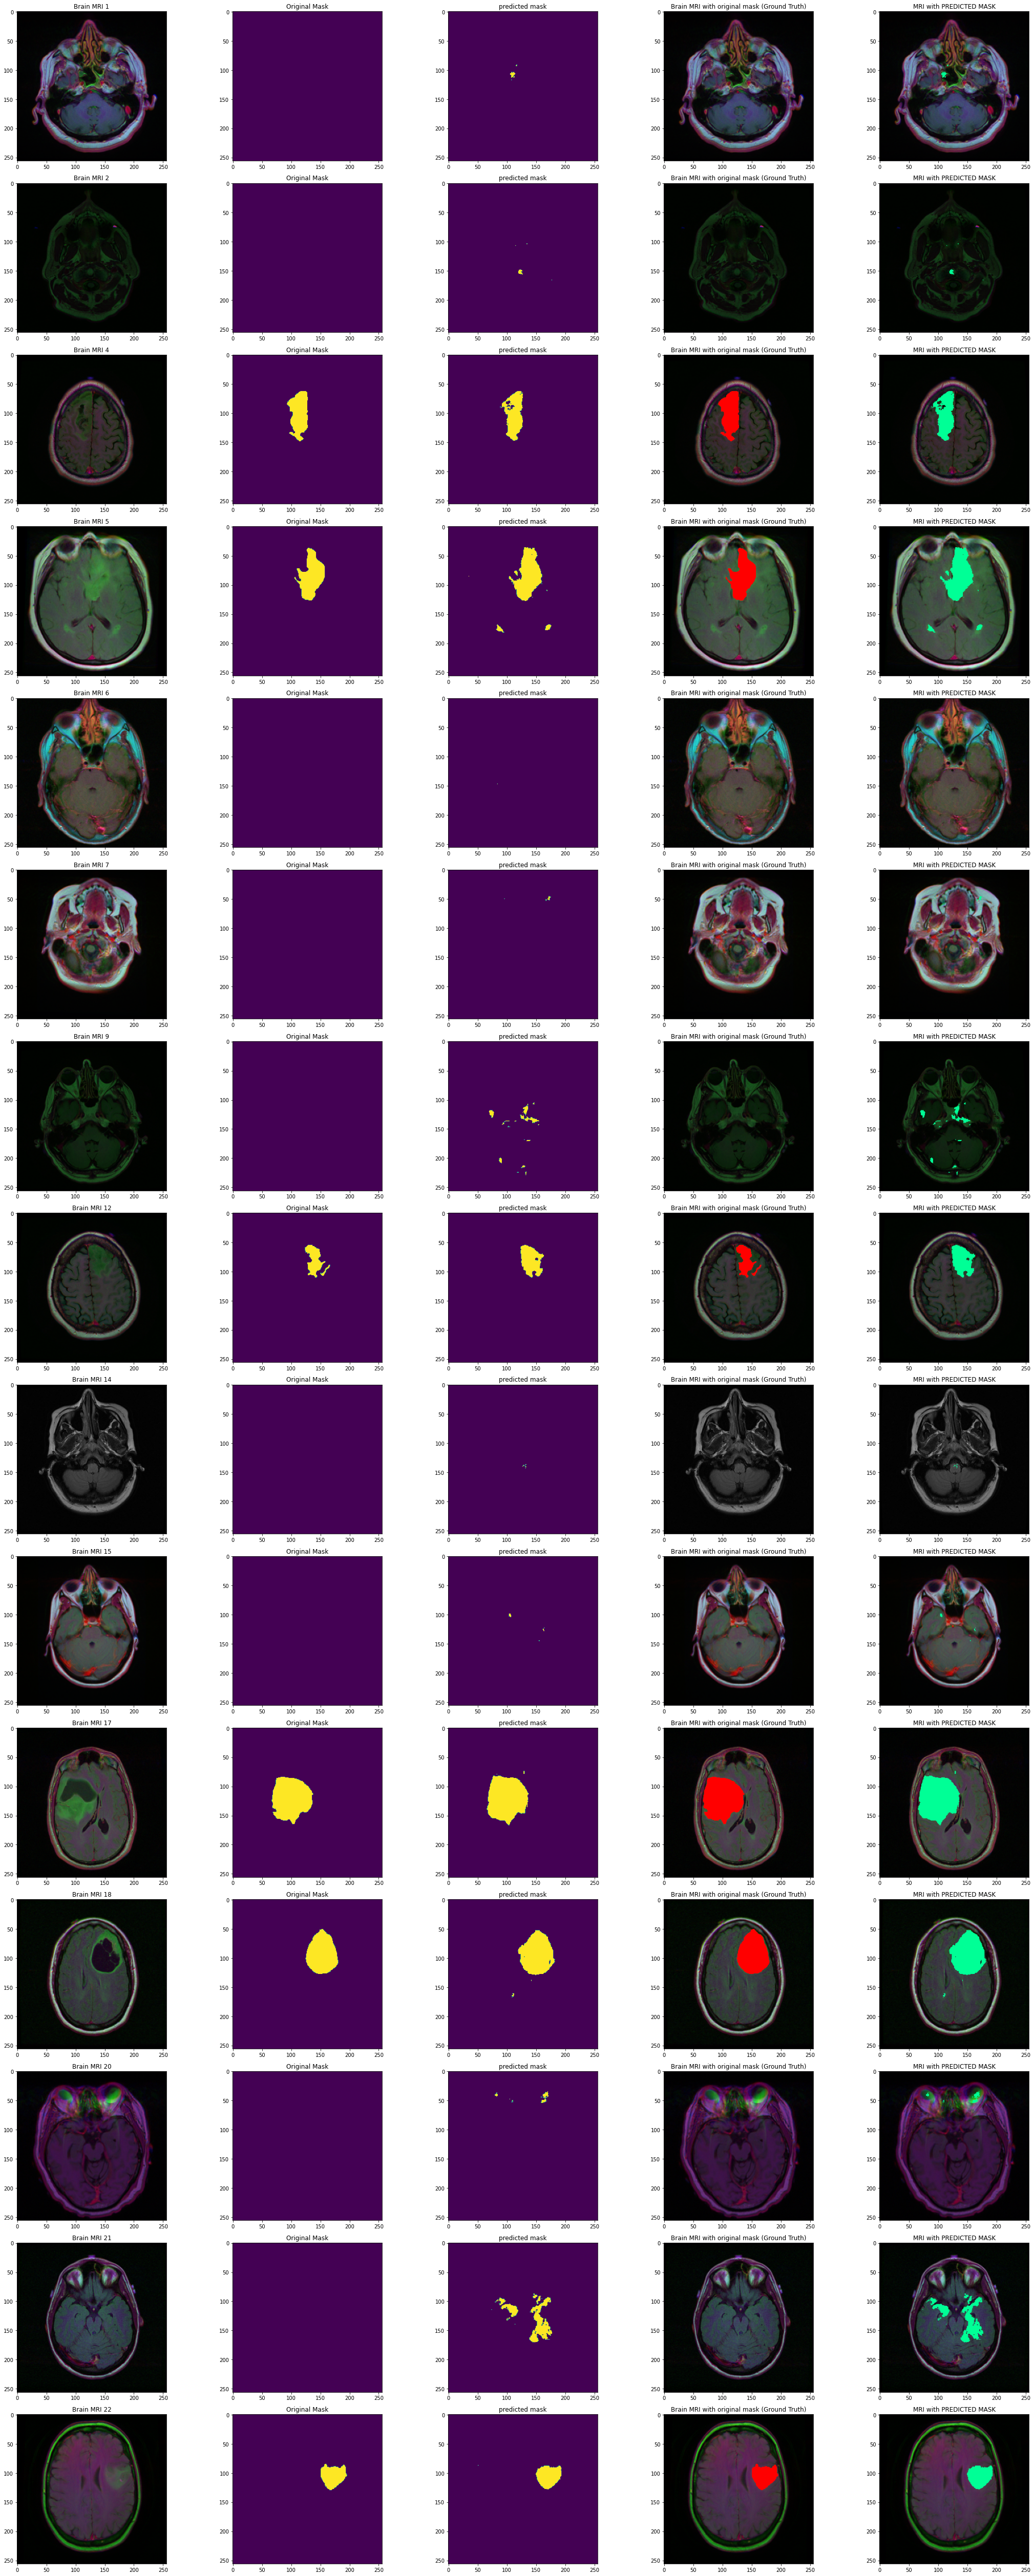

In [ ]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI {}'.format(i))
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()       

<h1>Federated Rounds Start</h1>

In [ ]:
#initiate a base model

def generate_seg_model():
    input_shape = (256,256,3)
    X_input = Input(input_shape) #iniating tensor of input shape

    # Stage 1
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPool2D((2,2))(conv_1)

    # stage 2
    conv_2 = resblock(pool_1, 32)
    pool_2 = MaxPool2D((2,2))(conv_2)

    # Stage 3
    conv_3 = resblock(pool_2, 64)
    pool_3 = MaxPool2D((2,2))(conv_3)

    # Stage 4
    conv_4 = resblock(pool_3, 128)
    pool_4 = MaxPool2D((2,2))(conv_4)

    # Stage 5 (bottle neck)
    conv_5 = resblock(pool_4, 256)

    # Upsample Stage 1
    up_1 = upsample_concat(conv_5, conv_4)
    up_1 = resblock(up_1, 128)

    # Upsample Stage 2
    up_2 = upsample_concat(up_1, conv_3)
    up_2 = resblock(up_2, 64)

    # Upsample Stage 3
    up_3 = upsample_concat(up_2, conv_2)
    up_3 = resblock(up_3, 32)

    # Upsample Stage 4
    up_4 = upsample_concat(up_3, conv_1)
    up_4 = resblock(up_4, 16)

    # final output
    out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

    seg_model = Model(X_input, out)
    return seg_model

<h1>Creating data slices for each client</h1>

In [ ]:
def create_data_slice(brain_df):
    state_val=random.randint(1, 50)
    test_size_val=round(random.uniform(0.1, 0.2),2)
    data_set_random_frac=round(random.uniform(0.4, 0.8),2)
    
    #randomizing data to simulate real world scenario
    brain_df_mask = brain_df[brain_df['mask'] == 1].sample(frac=data_set_random_frac)
    X_train, X_val = train_test_split(brain_df_mask, test_size=test_size_val, random_state=state_val)
    X_test, X_val = train_test_split(X_val, test_size=0.5)
    
    train_ids = list(X_train.image_path)
    train_mask = list(X_train.mask_path)

    val_ids = list(X_val.image_path)
    val_mask= list(X_val.mask_path)
    
    train_data = DataGenerator(train_ids, train_mask)
    val_data = DataGenerator(val_ids, val_mask)
    
    print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))
    
    return (train_data, val_data, X_test)

In [ ]:
def start_training(model, brain_df, round_no, clinet_no):
    # compling model and callbacks functions
    adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
    model.compile(optimizer = adam, 
                      loss='mse', #loss = focal_tversky, 
                      metrics = [iou_coef]
                     )
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss',
                                  mode='min', 
                                  verbose=1, 
                                  patience=10
                                 )
    # save the best model with lower validation loss
    checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights_round{}_clinet{}.hdf5".format(round_no, clinet_no), 
                                   verbose=1, 
                                   save_best_only=True
                                  )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  mode='min',
                                  verbose=1,
                                  patience=10,
                                  min_delta=0.0001,
                                  factor=0.2
                                 )
    
    train_data, val_data, X_test=create_data_slice(brain_df)
    
    h = model.fit(train_data, 
                  epochs = 3, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )
    test_ids = list(X_test.image_path)
    test_mask = list(X_test.mask_path)
    test_data = DataGenerator(test_ids, test_mask)
    _, tv = model.evaluate(test_data)
    print("Segmentation IOU is {:.2f}%".format(tv*100))
    
    return (model, h, X_test, tv)

In [ ]:
from keras.models import clone_model
# create a model from the weights of multiple models
def fed_avg(members, weights):
    # determine how many layers need to be averaged
    n_layers = len(members[0].get_weights())
    # create an set of average model weights
    avg_model_weights = list()
    for layer in range(n_layers):
        # collect this layer from each model
        layer_weights = np.array([model.get_weights()[layer] for model in members])
        # weighted average of weights for this layer
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        # store average layer weights
        avg_model_weights.append(avg_layer_weights)
    # create a new model with the same structure
    model = clone_model(members[0])
    # set the weights in the new
    model.set_weights(avg_model_weights)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
import datetime
def run_federated_rounds(clinet_perround=4, no_of_rounds=8):
    per_round_fedavg_models=[]
    stats=[]
    for i in range(no_of_rounds):
        round_start=datetime.datetime.now()
        this_round_client_trained_models=[]
        sample_size=[]
        print ('')
        print ('')
        print ('***********Federated Round {} **************'.format(i+1))
        for j in range(clinet_perround):
            print ('')
            print ('-------------------------')
            print ('client {} training'.format(j+1))
            if i==0:
                client_model=generate_seg_model()
            else:
                client_model=this_round_fed_avg_model

            model, h , X_test, temp_tv= start_training(client_model, brain_df, i, j)
            sample_size.append(X_test['image_path'].count())
            stats.append({'round': i, 'client': j, 'test_IOU': temp_tv})
            this_round_client_trained_models.append(model)
    
        n_models = len(this_round_client_trained_models)
        wt_sum=sum(sample_size)
        weights=[i/wt_sum for i in sample_size]
        print ("models will be weighted as per below ratio based on their data contribution")
        print (weights)
        this_round_fed_avg_model = fed_avg(this_round_client_trained_models, weights)   
        
        orig_test_ids = list(test.image_path)
        orig_test_mask = list(test.mask_path)
        orig_test_data = DataGenerator(orig_test_ids, orig_test_mask)
        _, tv = this_round_fed_avg_model.evaluate(orig_test_data)
        print("FedAvg Segmentation IOU is {:.2f}%".format(tv*100))
        
        per_round_fedavg_models.append({'round': i, 'fed_avg_model': this_round_fed_avg_model, 'fed_avg_test_IOU': tv})
        round_end=datetime.datetime.now()
        this_round_fed_avg_model.save('FedAvg_Model_Round_{}.hdf5'.format(i))
        print ('Round {} computation done in : {}'.format(i, str(round_end-round_start)))
        print (stats)
    return (per_round_fedavg_models, stats)

In [ ]:
(per_round_fedavg_models, stats)=run_federated_rounds()



***********Federated Round 1 **************

-------------------------
client 1 training
Train size is 809, valid size is 83 & test size is 83
Epoch 1/3
50/50 [==============================] - 11s 154ms/step - loss: 0.2740 - iou_coef: 0.0337 - val_loss: 0.0370 - val_iou_coef: 0.0315

Epoch 00001: val_loss improved from inf to 0.03699, saving model to ResUNet-segModel-weights_round0_clinet0.hdf5
Epoch 2/3
50/50 [==============================] - 6s 125ms/step - loss: 0.0297 - iou_coef: 0.0670 - val_loss: 0.0294 - val_iou_coef: 0.0666

Epoch 00002: val_loss improved from 0.03699 to 0.02940, saving model to ResUNet-segModel-weights_round0_clinet0.hdf5
Epoch 3/3
50/50 [==============================] - 6s 122ms/step - loss: 0.0217 - iou_coef: 0.1050 - val_loss: 0.0224 - val_iou_coef: 0.1045

Epoch 00003: val_loss improved from 0.02940 to 0.02242, saving model to ResUNet-segModel-weights_round0_clinet0.hdf5
5/5 [==============================] - 1s 107ms/step - loss: 0.0228 - iou_coef: 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning:

invalid value encountered in true_divide



36/36 [==============================] - 5s 111ms/step - loss: 0.0000e+00 - accuracy: 0.9911
FedAvg Segmentation IOU is 99.07%
Round 0 computation done in : 0:02:20.357907
[{'round': 0, 'client': 0, 'test_IOU': 0.10015831142663956}, {'round': 0, 'client': 1, 'test_IOU': 0.1326724737882614}, {'round': 0, 'client': 2, 'test_IOU': 0.10876376926898956}, {'round': 0, 'client': 3, 'test_IOU': 0.06674759089946747}]


***********Federated Round 2 **************

-------------------------
client 1 training
Train size is 899, valid size is 86 & test size is 86
Epoch 1/3
56/56 [==============================] - 11s 139ms/step - loss: 0.0338 - iou_coef: 0.0381 - val_loss: 0.0530 - val_iou_coef: 0.0307

Epoch 00001: val_loss improved from inf to 0.05298, saving model to ResUNet-segModel-weights_round1_clinet0.hdf5
Epoch 2/3
56/56 [==============================] - 7s 119ms/step - loss: 0.0229 - iou_coef: 0.0765 - val_loss: 0.0400 - val_iou_coef: 0.0399

Epoch 00002: val_loss improved from 0.05298 t

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning:

invalid value encountered in true_divide



36/36 [==============================] - 5s 105ms/step - loss: 0.0000e+00 - accuracy: 0.9887
FedAvg Segmentation IOU is 98.81%
Round 1 computation done in : 0:02:04.746698
[{'round': 0, 'client': 0, 'test_IOU': 0.10015831142663956}, {'round': 0, 'client': 1, 'test_IOU': 0.1326724737882614}, {'round': 0, 'client': 2, 'test_IOU': 0.10876376926898956}, {'round': 0, 'client': 3, 'test_IOU': 0.06674759089946747}, {'round': 1, 'client': 0, 'test_IOU': 0.0660831555724144}, {'round': 1, 'client': 1, 'test_IOU': 0.1513180434703827}, {'round': 1, 'client': 2, 'test_IOU': 0.2037017047405243}, {'round': 1, 'client': 3, 'test_IOU': 0.2591586112976074}]


***********Federated Round 3 **************

-------------------------
client 1 training
Train size is 930, valid size is 64 & test size is 63
Epoch 1/3
58/58 [==============================] - 11s 136ms/step - loss: 0.0128 - iou_coef: 0.2374 - val_loss: 0.0128 - val_iou_coef: 0.2394

Epoch 00001: val_loss improved from inf to 0.01275, saving model

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning:

invalid value encountered in true_divide



36/36 [==============================] - 5s 111ms/step - loss: 0.0000e+00 - accuracy: 0.9894
FedAvg Segmentation IOU is 98.93%
Round 2 computation done in : 0:02:08.886665
[{'round': 0, 'client': 0, 'test_IOU': 0.10015831142663956}, {'round': 0, 'client': 1, 'test_IOU': 0.1326724737882614}, {'round': 0, 'client': 2, 'test_IOU': 0.10876376926898956}, {'round': 0, 'client': 3, 'test_IOU': 0.06674759089946747}, {'round': 1, 'client': 0, 'test_IOU': 0.0660831555724144}, {'round': 1, 'client': 1, 'test_IOU': 0.1513180434703827}, {'round': 1, 'client': 2, 'test_IOU': 0.2037017047405243}, {'round': 1, 'client': 3, 'test_IOU': 0.2591586112976074}, {'round': 2, 'client': 0, 'test_IOU': 0.2971518933773041}, {'round': 2, 'client': 1, 'test_IOU': 0.3596935570240021}, {'round': 2, 'client': 2, 'test_IOU': 0.3512769937515259}, {'round': 2, 'client': 3, 'test_IOU': 0.3489765226840973}]


***********Federated Round 4 **************

-------------------------
client 1 training
Train size is 842, valid 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning:

invalid value encountered in true_divide



36/36 [==============================] - 5s 105ms/step - loss: 0.0000e+00 - accuracy: 0.9956
FedAvg Segmentation IOU is 99.54%
Round 3 computation done in : 0:01:57.685973
[{'round': 0, 'client': 0, 'test_IOU': 0.10015831142663956}, {'round': 0, 'client': 1, 'test_IOU': 0.1326724737882614}, {'round': 0, 'client': 2, 'test_IOU': 0.10876376926898956}, {'round': 0, 'client': 3, 'test_IOU': 0.06674759089946747}, {'round': 1, 'client': 0, 'test_IOU': 0.0660831555724144}, {'round': 1, 'client': 1, 'test_IOU': 0.1513180434703827}, {'round': 1, 'client': 2, 'test_IOU': 0.2037017047405243}, {'round': 1, 'client': 3, 'test_IOU': 0.2591586112976074}, {'round': 2, 'client': 0, 'test_IOU': 0.2971518933773041}, {'round': 2, 'client': 1, 'test_IOU': 0.3596935570240021}, {'round': 2, 'client': 2, 'test_IOU': 0.3512769937515259}, {'round': 2, 'client': 3, 'test_IOU': 0.3489765226840973}, {'round': 3, 'client': 0, 'test_IOU': 0.35316717624664307}, {'round': 3, 'client': 1, 'test_IOU': 0.3879892826080322

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning:

invalid value encountered in true_divide



36/36 [==============================] - 5s 109ms/step - loss: 0.0000e+00 - accuracy: 0.9957
FedAvg Segmentation IOU is 99.55%
Round 4 computation done in : 0:02:04.878356
[{'round': 0, 'client': 0, 'test_IOU': 0.10015831142663956}, {'round': 0, 'client': 1, 'test_IOU': 0.1326724737882614}, {'round': 0, 'client': 2, 'test_IOU': 0.10876376926898956}, {'round': 0, 'client': 3, 'test_IOU': 0.06674759089946747}, {'round': 1, 'client': 0, 'test_IOU': 0.0660831555724144}, {'round': 1, 'client': 1, 'test_IOU': 0.1513180434703827}, {'round': 1, 'client': 2, 'test_IOU': 0.2037017047405243}, {'round': 1, 'client': 3, 'test_IOU': 0.2591586112976074}, {'round': 2, 'client': 0, 'test_IOU': 0.2971518933773041}, {'round': 2, 'client': 1, 'test_IOU': 0.3596935570240021}, {'round': 2, 'client': 2, 'test_IOU': 0.3512769937515259}, {'round': 2, 'client': 3, 'test_IOU': 0.3489765226840973}, {'round': 3, 'client': 0, 'test_IOU': 0.35316717624664307}, {'round': 3, 'client': 1, 'test_IOU': 0.3879892826080322

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning:

invalid value encountered in true_divide



36/36 [==============================] - 5s 105ms/step - loss: 0.0000e+00 - accuracy: 0.9944
FedAvg Segmentation IOU is 99.34%
Round 5 computation done in : 0:01:54.037504
[{'round': 0, 'client': 0, 'test_IOU': 0.10015831142663956}, {'round': 0, 'client': 1, 'test_IOU': 0.1326724737882614}, {'round': 0, 'client': 2, 'test_IOU': 0.10876376926898956}, {'round': 0, 'client': 3, 'test_IOU': 0.06674759089946747}, {'round': 1, 'client': 0, 'test_IOU': 0.0660831555724144}, {'round': 1, 'client': 1, 'test_IOU': 0.1513180434703827}, {'round': 1, 'client': 2, 'test_IOU': 0.2037017047405243}, {'round': 1, 'client': 3, 'test_IOU': 0.2591586112976074}, {'round': 2, 'client': 0, 'test_IOU': 0.2971518933773041}, {'round': 2, 'client': 1, 'test_IOU': 0.3596935570240021}, {'round': 2, 'client': 2, 'test_IOU': 0.3512769937515259}, {'round': 2, 'client': 3, 'test_IOU': 0.3489765226840973}, {'round': 3, 'client': 0, 'test_IOU': 0.35316717624664307}, {'round': 3, 'client': 1, 'test_IOU': 0.3879892826080322

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning:

invalid value encountered in true_divide



36/36 [==============================] - 5s 109ms/step - loss: 0.0000e+00 - accuracy: 0.9945
FedAvg Segmentation IOU is 99.35%
Round 6 computation done in : 0:02:16.500399
[{'round': 0, 'client': 0, 'test_IOU': 0.10015831142663956}, {'round': 0, 'client': 1, 'test_IOU': 0.1326724737882614}, {'round': 0, 'client': 2, 'test_IOU': 0.10876376926898956}, {'round': 0, 'client': 3, 'test_IOU': 0.06674759089946747}, {'round': 1, 'client': 0, 'test_IOU': 0.0660831555724144}, {'round': 1, 'client': 1, 'test_IOU': 0.1513180434703827}, {'round': 1, 'client': 2, 'test_IOU': 0.2037017047405243}, {'round': 1, 'client': 3, 'test_IOU': 0.2591586112976074}, {'round': 2, 'client': 0, 'test_IOU': 0.2971518933773041}, {'round': 2, 'client': 1, 'test_IOU': 0.3596935570240021}, {'round': 2, 'client': 2, 'test_IOU': 0.3512769937515259}, {'round': 2, 'client': 3, 'test_IOU': 0.3489765226840973}, {'round': 3, 'client': 0, 'test_IOU': 0.35316717624664307}, {'round': 3, 'client': 1, 'test_IOU': 0.3879892826080322

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning:

invalid value encountered in true_divide



36/36 [==============================] - 5s 105ms/step - loss: 0.0000e+00 - accuracy: 0.9960
FedAvg Segmentation IOU is 99.56%
Round 7 computation done in : 0:02:07.405636
[{'round': 0, 'client': 0, 'test_IOU': 0.10015831142663956}, {'round': 0, 'client': 1, 'test_IOU': 0.1326724737882614}, {'round': 0, 'client': 2, 'test_IOU': 0.10876376926898956}, {'round': 0, 'client': 3, 'test_IOU': 0.06674759089946747}, {'round': 1, 'client': 0, 'test_IOU': 0.0660831555724144}, {'round': 1, 'client': 1, 'test_IOU': 0.1513180434703827}, {'round': 1, 'client': 2, 'test_IOU': 0.2037017047405243}, {'round': 1, 'client': 3, 'test_IOU': 0.2591586112976074}, {'round': 2, 'client': 0, 'test_IOU': 0.2971518933773041}, {'round': 2, 'client': 1, 'test_IOU': 0.3596935570240021}, {'round': 2, 'client': 2, 'test_IOU': 0.3512769937515259}, {'round': 2, 'client': 3, 'test_IOU': 0.3489765226840973}, {'round': 3, 'client': 0, 'test_IOU': 0.35316717624664307}, {'round': 3, 'client': 1, 'test_IOU': 0.3879892826080322

In [ ]:
#final data validation with the averaged model at end of 8 rounds
fed_avg_df_pred = prediction(test, per_round_fedavg_models[-1]['fed_avg_model'])
final_fedavg_df_pred = test.merge(fed_avg_df_pred, on='image_path')

In [ ]:
def viz_pred(df_pred, fed_avg_df_pred):
    #visualizing prediction
    count = 0
    fig, axs = plt.subplots(10,7, figsize=(28,50))

    for i in range(len(df_pred)):
        if df_pred.has_mask[i]==1 and final_fedavg_df_pred.has_mask[i]==1 and count<10:
            #read mri images
            img = io.imread(df_pred.image_path[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[count][0].imshow(img)
            axs[count][0].title.set_text('Brain MRI')

            #read original mask
            mask = io.imread(df_pred.mask_path[i])
            axs[count][1].imshow(mask)
            axs[count][1].title.set_text('Original Mask')

            #read predicted mask(central)
            central_pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
            axs[count][2].imshow(central_pred)
            axs[count][2].title.set_text('AI predicted mask(central)')
            
            #read predicted mask(fed)
            fed_pred = np.array(final_fedavg_df_pred.predicted_mask[i]).squeeze().round()
            axs[count][3].imshow(fed_pred)
            axs[count][3].title.set_text('AI predicted mask(fed)')

            #overlay original mask with MRI
            img[mask==255] = (255,0,0)
            axs[count][4].imshow(img)
            axs[count][4].title.set_text('Brain MRI with original mask (Ground Truth)')

            #overlay predicted mask and MRI
            img_ = io.imread(df_pred.image_path[i])
            img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
            img_[central_pred==1] = (0,255,150)
            axs[count][5].imshow(img_)
            axs[count][5].title.set_text('MRI with AI PREDICTED MASK(CENTRAL)')
            
            #overlay predicted mask and MRI
            img_ = io.imread(final_fedavg_df_pred.image_path[i])
            img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
            img_[fed_pred==1] = (0,255,150)
            axs[count][6].imshow(img_)
            axs[count][6].title.set_text('MRI with AI PREDICTED MASK(FED)')
            
            count +=1
        if (count==10):
            break
    
#     fig.tight_layout()  
    fig.savefig('Central_VS_Fed.png')

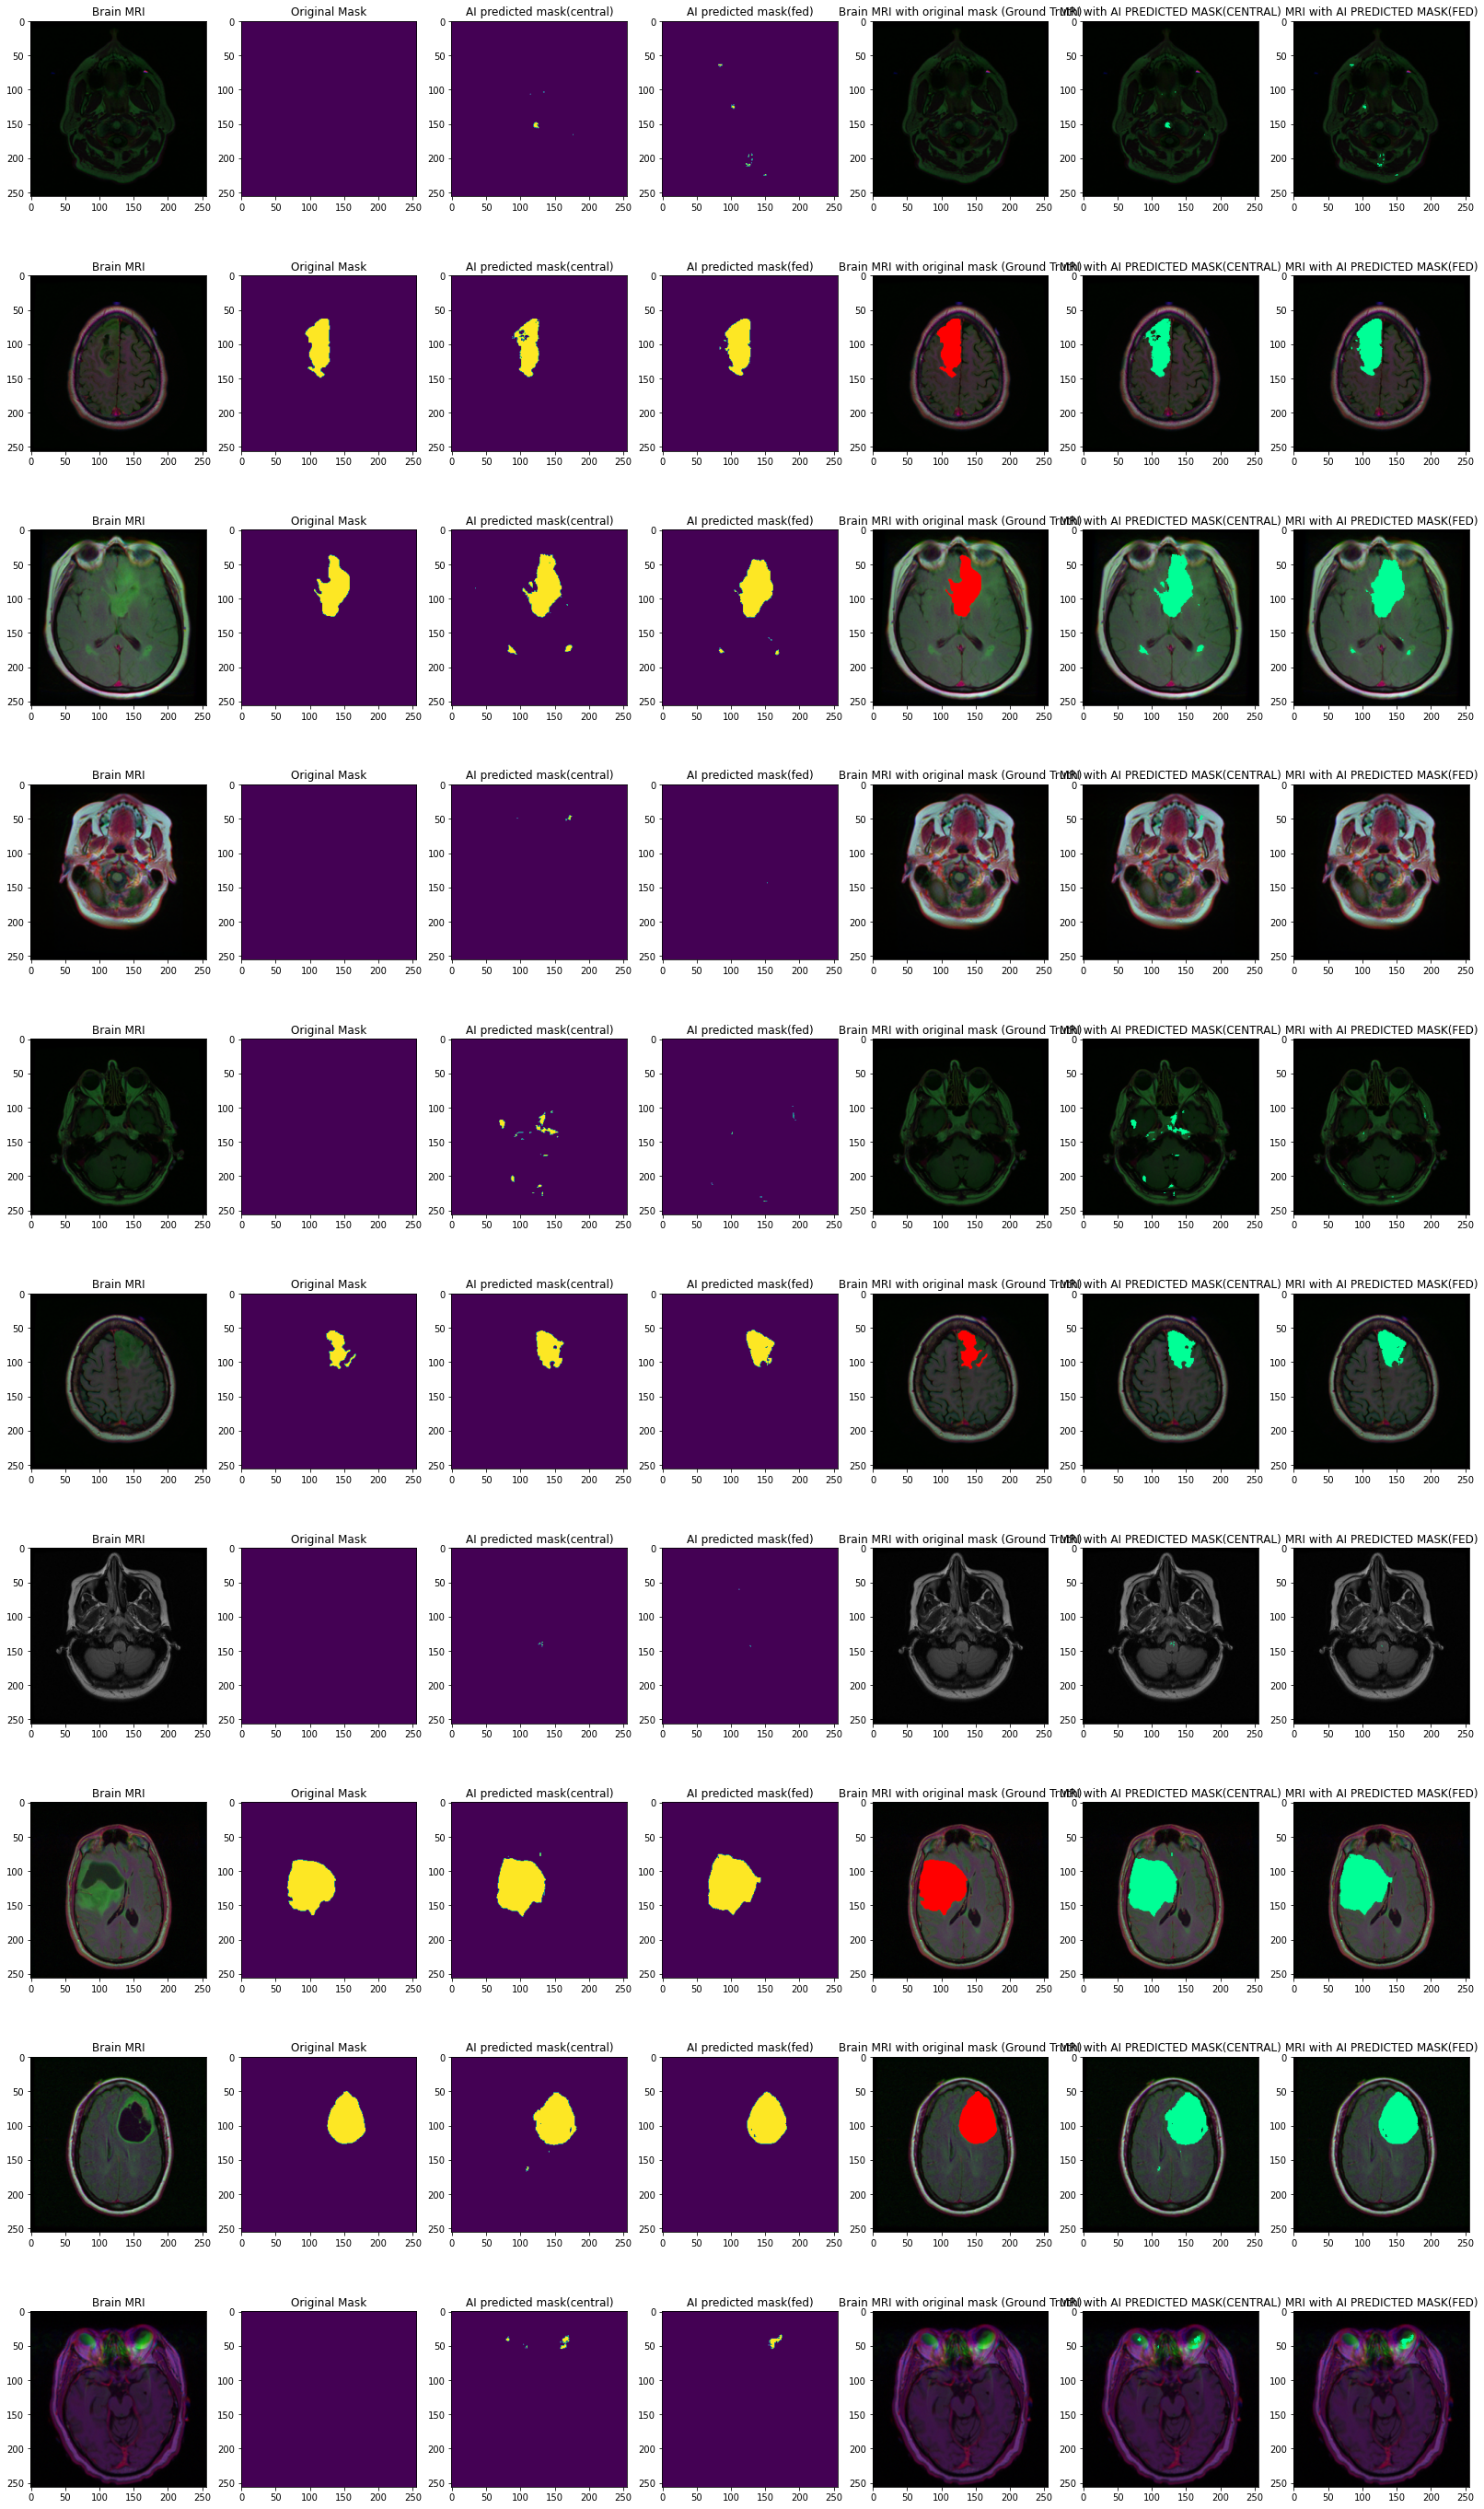

In [ ]:
viz_pred(df_pred, final_fedavg_df_pred)

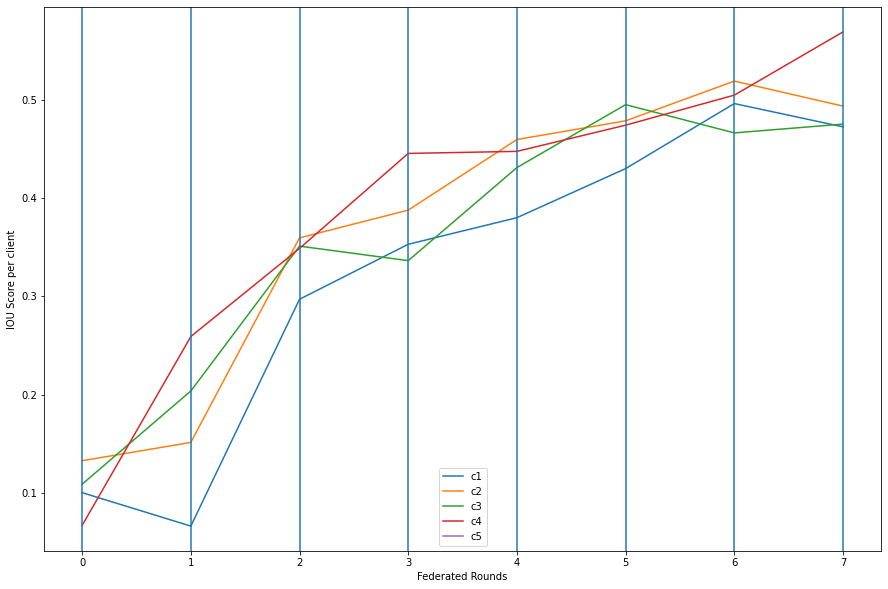

In [ ]:
round_wise_clinet_iou={'c1':[], 'c2':[], 'c3':[], 'c4':[], 'c5':[]}
for i in stats:
    if i['client']==0:
        round_wise_clinet_iou['c1'].append(i['test_IOU'])
    if i['client']==1:
        round_wise_clinet_iou['c2'].append(i['test_IOU'])
    if i['client']==2:
        round_wise_clinet_iou['c3'].append(i['test_IOU'])
    if i['client']==3:
        round_wise_clinet_iou['c4'].append(i['test_IOU'])
    if i['client']==4:
        round_wise_clinet_iou['c5'].append(i['test_IOU'])
fig=plt.figure(figsize=(15,10))

plt.plot(round_wise_clinet_iou['c1'])
plt.plot(round_wise_clinet_iou['c2'])
plt.plot(round_wise_clinet_iou['c3'])
plt.plot(round_wise_clinet_iou['c4'])
plt.plot(round_wise_clinet_iou['c5'])
plt.axvline(x=0 )
plt.axvline(x=1.0)
plt.axvline(x=2.0)
plt.axvline(x=3.0)
plt.axvline(x=4.0)
plt.axvline(x=5.0)
plt.axvline(x=6.0)
plt.axvline(x=7.0)
plt.legend(['c1','c2', 'c3', 'c4', 'c5'])
plt.xlabel('Federated Rounds')
plt.ylabel('IOU Score per client')

plt.savefig('clientwise_iou_improvement.png')

In [ ]:
import time
while True:
    time.sleep(600)

KeyboardInterrupt: 